# Librairies


In [36]:
import numpy as np 
import matplotlib.pyplot as plt 
import time
import pyreadr
import xarray

# Préalable

## Initialisation

In [48]:
def initialize(ni,ri):
    Ui = np.zeros((ni, ri))
    indices = np.array_split(np.arange(ni), ri)
    for j, idx in enumerate(indices):
        print(f"j: {j}, idx: {idx}")
        Ui[idx, j] = 1 / np.sqrt(len(idx))

    return Ui

def initialize_(ni,ri):
    Ui = np.random.rand(ni, ri)

    return Ui

def initialize_G(r1,r2,r3):
    G= np.random.rand(r1,r2,r3)

    return G

In [51]:
U=initialize(12,3)
print(U)

j: 0, idx: [0 1 2 3]
j: 1, idx: [4 5 6 7]
j: 2, idx: [ 8  9 10 11]
[[0.5 0.  0. ]
 [0.5 0.  0. ]
 [0.5 0.  0. ]
 [0.5 0.  0. ]
 [0.  0.5 0. ]
 [0.  0.5 0. ]
 [0.  0.5 0. ]
 [0.  0.5 0. ]
 [0.  0.  0.5]
 [0.  0.  0.5]
 [0.  0.  0.5]
 [0.  0.  0.5]]


## Calcul de l'erreur

In [38]:
def etalT(T):
    n1, n2, n3 = T.shape
    T_prime=T.reshape(n1, n2 * n3)
    return T_prime

def U23G(U2, U3, G):
    # étape 0 : 
    G_=G[:,:,0]*U3[0,0]
    for i in range (1,U3.shape[1]):   
        G_=G_+G[:,:,i]*U3[0,i]
    U23=G_@U2.T

    for j in range (1, U3.shape[0]):
        G_=G[:,:,0]*U3[j,0]
        for i in range (1,U3.shape[1]):   
            G_=G_+G[:,:,i]*U3[j,i]
        U23=np.bmat([[U23 , G_@U2.T]])
    return U23

def calcul_error(T, G, U1, U2, U3):
    Mat=U1 @ U23G(U2, U3, G)
    T_prime=etalT(T)
    error=np.linalg.norm(T_prime-Mat)**2/np.linalg.norm(T_prime)**2
    return error
def calcul_e(T_,U,i,U23g):
    Mat=U @ U23g  
    t=T_[i,:]
    error=np.linalg.norm(t-Mat)**2/np.linalg.norm(t)**2
    return error

def U_normalize(U):
    m,n=U.shape
    for i in range(n):
        norm=np.linalg.norm(U[:,i])
        if norm > 0 and norm == True:   
            U[:,i]=U[:,i]/norm
    return U

## Optimisation

In [39]:
def mode_n_product(X, M, mode):
    Xm = np.moveaxis(X, mode, 0)            
    Y = np.tensordot(M, Xm, axes=(1,0))      
    return np.moveaxis(Y, 0, mode) 

def optiG(T,U1,U2,U3,G,rcond=None):

    U1=U_normalize(U1)
    U2=U_normalize(U2)
    U3=U_normalize(U3)
    
    pinv1 = U1.T
    pinv2 = U2.T
    pinv3 = U3.T
    G = mode_n_product(T, pinv1, mode=0)
    G = mode_n_product(G, pinv2, mode=1)
    G = mode_n_product(G, pinv3, mode=2)
    return G

In [40]:
def optiU(T, U, U2, U3, G):
    T_ = etalT(T)
    n1 = T.shape[0]
    r1 = G.shape[0]

    U_save = U.copy()
    value_save = calcul_error(T, G, U_save, U2, U3)

    U23g = U23G(U2, U3, G)  
    eps = 1e-12  

    for i in range(n1):

        best_j = 0
        best_err = float('inf')
        best_val = 0
        #Uiprev = U[i, :].copy()
        #err0 = calcul_e(T_, Uiprev, i, U23g)
        #print(f"i: {i}, err0: {err0}")
        for j in range(r1):

            #U_tmp = U[i,:].copy()
            #U_tmp[:] = 0
            Ulignei = np.zeros(r1)

            denom = np.linalg.norm(U23g[j, :])**2 + eps
            Ulignei[j] = (T_[i, :] @ U23g[j, :].T) / denom

            #U_test = U.copy()
            #U_test[i, :] = U_tmp

            err = calcul_e(T_, Ulignei, i, U23g)
            #print(f"i: {i}, j: {j}, err: {err}, best_err: {best_err}")
            if err < best_err:
                best_err = err
                best_val = Ulignei[j]
                best_j = j

        U[i, :] = 0
        #denom = np.linalg.norm(U23g[best_j, :])**2 + eps
        U[i, best_j] = best_val #(T_[i, :] @ U23g[best_j, :].T) / denom
        #Uiprev = U[i, :].copy()
        #err0 = calcul_e(T_, Uiprev, i, U23g)
        #print(f"i: {i}, err1: {err0}")

    err= calcul_error(T, G, U, U2, U3)
    return U, err

In [71]:
def Optimization(T, U1, U2, U3, G, max_iter=10,maxtime=300,tol=1e-6):
    erreurU1=[]
    erreurU2=[]
    erreurU3=[]
    start_time=time.time()

    for i in range (max_iter):


        T1 = T  
        print(f"erreur avant : {calcul_error (T,G,U1,U2,U3)}")
        U1,err = optiU(T1, U1, U2, U3, G)
        erreurU1.append(err)
        print(f"Erreur après : {err}")
        print(U1)

        T2 = np.transpose(T, (1, 0, 2))  
        print(f"erreur avant : {calcul_error(T2,np.transpose(G, (1, 0, 2)),U2,U1,U3)}")
        U2,err = optiU(T2, U2, U1, U3, np.transpose(G, (1, 0, 2)))
        erreurU2.append(err)
        print(f"Erreur U2 : {err}")
        print(U2)

      
        T3 = np.transpose(T, (2, 0, 1))  
        print(f"erreur avant : {calcul_error (T3,np.transpose(G, (2, 0, 1)),U3,U1,U2)}")
        U3,err = optiU(T3, U3, U1, U2, np.transpose(G, (2, 0, 1)))

        erreurU3.append(err)
        print(f"Erreur U3 : {err}")
        print(U2)


        G=optiG(T,U1,U2,U3,G)

        error=calcul_error (T,G,U1,U2,U3)
        if erreurU1[-1]<tol or erreurU2[-1]<tol or erreurU3[-1]<tol:
            print("Seuil de tolérance atteint")
            break
        if time.time()-start_time>maxtime:
            print("Temps maximum écoulé")
            break
        print(f"__________itération {i+1} __________")
    return U1,U2,U3,G,erreurU1,erreurU2,erreurU3

## Print

In [42]:
def print_results(erreurU1,erreurU2,erreurU3):
    plt.plot(erreurU1, label='Erreur U1')
    plt.plot(erreurU2, label='Erreur U2')
    plt.plot(erreurU3, label='Erreur U3')
    plt.yscale('log')
    plt.xlabel('Itérations')
    plt.ylabel('Erreur')
    plt.title('Convergence des erreurs')
    plt.legend()
    plt.show()

# Algo

Variables

In [43]:
max_iter=5
tol=1e-6
maxtime=150

In [68]:
#Jeu de données US airport

T_flat = np.load("airport_tensor.npy")   # shape = (8117781,)
print(T_flat.shape)

# R a "aplatit" en ordre colonne → on remet en forme avec order="F"
T = T_flat.reshape((343, 343, 69), order="F")

print(T.shape)              # doit afficher (343, 343, 69)
print(T[:10, :10, 0])       # les 10x10 premiers de la 1ère matrice

(8117781,)
(343, 343, 69)
[[  0. 273. 138.   0. 126.   0.   0.   0.  31. 132.]
 [276.   0. 462. 255. 459. 255. 303.  87. 262. 182.]
 [134. 462.   0.  79. 292.  71. 169.  21. 183.  87.]
 [  0. 256.  74.   0. 318.   0.   1.   0.  55. 129.]
 [130. 464. 293. 302.   0. 130. 110.   0. 125.   0.]
 [  0. 256.  70.   0. 131.   0.   1.   0.   0.   0.]
 [  0. 303. 169.   1. 101.   0.   0.   0.  51. 102.]
 [  0.  87.  22.   0.   0.   0.   0.   0.   0.   0.]
 [ 31. 262. 181.  56. 128.   0.  56.   0.   0.  27.]
 [133. 184.  86. 128.   0.   0. 101.   0.  26.   0.]]


In [69]:
np.random.seed(42)
T=T[:10, :10, :10]
n1,n2,n3=T.shape
r1=3
r2=4
r3=5
U1=initialize(n1,r1)
U2=initialize(n2,r2)
U3=initialize(n3,r3)
G=initialize_G(r1,r2,r3)

j: 0, idx: [0 1 2 3]
j: 1, idx: [4 5 6]
j: 2, idx: [7 8 9]
j: 0, idx: [0 1 2]
j: 1, idx: [3 4 5]
j: 2, idx: [6 7]
j: 3, idx: [8 9]
j: 0, idx: [0 1]
j: 1, idx: [2 3]
j: 2, idx: [4 5]
j: 3, idx: [6 7]
j: 4, idx: [8 9]


In [67]:
U1=initialize(n1,r1)
print("Initial U1:")
print(U1)
U1,err=optiU(T,U1,U2,U3,G)
print("Optimized U1:")
print(U1)

j: 0, idx: [0 1 2 3]
j: 1, idx: [4 5 6]
j: 2, idx: [7 8 9]
Initial U1:
[[0.5        0.         0.        ]
 [0.5        0.         0.        ]
 [0.5        0.         0.        ]
 [0.5        0.         0.        ]
 [0.         0.57735027 0.        ]
 [0.         0.57735027 0.        ]
 [0.         0.57735027 0.        ]
 [0.         0.         0.57735027]
 [0.         0.         0.57735027]
 [0.         0.         0.57735027]]
Optimized U1:
[[   0.          266.86799168    0.        ]
 [1074.84846691    0.            0.        ]
 [   0.          645.05384665    0.        ]
 [ 287.67783724    0.            0.        ]
 [   0.            0.          533.00081515]
 [   0.          212.11257219    0.        ]
 [   0.          289.4272652     0.        ]
 [   0.           49.29061447    0.        ]
 [   0.            0.          295.48666217]
 [   0.          286.32186669    0.        ]]


/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_90626/261254285.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ulignei[j] = (T_[i, :] @ U23g[j, :].T) / denom


erreur avant : 1691641082751.9583
Erreur après : 0.6675823303617873
[[0.00000000e+00 0.00000000e+00 2.29727451e-06]
 [0.00000000e+00 0.00000000e+00 8.95304270e-06]
 [0.00000000e+00 0.00000000e+00 5.06830686e-06]
 [0.00000000e+00 0.00000000e+00 2.70786531e-06]
 [0.00000000e+00 0.00000000e+00 5.03198248e-06]
 [0.00000000e+00 0.00000000e+00 1.64861761e-06]
 [0.00000000e+00 0.00000000e+00 2.49591440e-06]
 [0.00000000e+00 0.00000000e+00 3.37617482e-07]
 [0.00000000e+00 0.00000000e+00 2.70105003e-06]
 [0.00000000e+00 0.00000000e+00 2.24757964e-06]]
erreur avant : 0.6389481659028986
Erreur U2 : 0.6280250832047419
[[0.         0.         0.72193592 0.        ]
 [0.         0.         2.78247437 0.        ]
 [0.         0.         1.56480604 0.        ]
 [0.         0.         0.83246994 0.        ]
 [0.         0.         1.55586563 0.        ]
 [0.         0.         0.49717987 0.        ]
 [0.         0.         0.77430616 0.        ]
 [0.         0.         0.10253486 0.        ]
 [0.      

/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_90626/261254285.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ulignei[j] = (T_[i, :] @ U23g[j, :].T) / denom
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_90626/2624950966.py:21: RuntimeWarning: divide by zero encountered in matmul
  Mat=U1 @ U23G(U2, U3, G)
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_90626/2624950966.py:21: RuntimeWarning: overflow encountered in matmul
  Mat=U1 @ U23G(U2, U3, G)
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_90626/2624950966.py:21: RuntimeWarning: invalid value encountered in matmul
  Mat=U1 @ U23G(U2, U3, G)


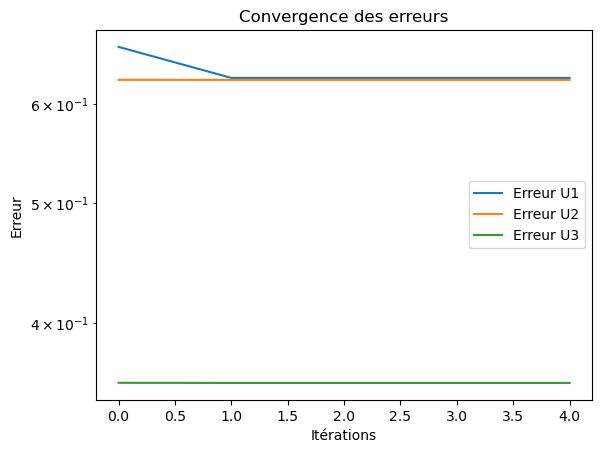

In [72]:
U1,U2,U3,G,erreurU1,erreurU2,erreurU3=Optimization(T, U1, U2, U3, G, max_iter,maxtime,tol)
print_results(erreurU1,erreurU2,erreurU3)